In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import PIL
import pickle
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plot
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
batch_size = 32

# 1. Обработка данных

In [4]:
class SimpsonsDataset(torch.utils.data.Dataset):
  def __init__(self, files, train, transform):
    super().__init__()
    self.files = files
    self.train = train
    self.transform = transform
    if self.train:
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder = LabelEncoder()
      self.label_encoder.fit(self.labels)
      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    path = str(self.files[index])
    image = Image.open(path)
    image = self.transform(image)
    if not self.train:
      return image
    label = self.label_encoder.transform([self.labels[index]]).item()
    return image, label

In [5]:
train_dir = './simpsons_dataset/'
test_dir = './kaggle_simpson_testset/'

In [6]:
train_path = sorted(list(Path(train_dir).rglob('*.jpg')))
test_path = sorted(list(Path(test_dir).rglob('*.jpg')))
train_labels = [path.parent.name for path in train_path]

train_files_path, val_files_path = train_test_split(train_path, test_size = 0.15, stratify=train_labels)
test_files_path = test_path

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [8]:
transform_train = torchvision.transforms.Compose([
     torchvision.transforms.Resize(256),
     torchvision.transforms.CenterCrop(224),  
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean, std),
])

train_dataset = SimpsonsDataset(files=train_files_path, train=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [23]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),  
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

test_dataset = SimpsonsDataset(files=test_files_path, train=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SimpsonsDataset(files=val_files_path, train=True, transform=transform_test)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
classes = set()
for folder in os.listdir(train_dir):
    classes.add(folder)
print(f'Classes of dataset: {classes}')

Classes of dataset: {'bart_simpson', 'nelson_muntz', 'maggie_simpson', 'marge_simpson', 'kent_brockman', 'rainier_wolfcastle', 'edna_krabappel', 'groundskeeper_willie', 'otto_mann', 'milhouse_van_houten', 'sideshow_bob', 'selma_bouvier', 'disco_stu', 'homer_simpson', 'comic_book_guy', 'troy_mcclure', 'agnes_skinner', 'principal_skinner', 'simpsons_dataset', 'cletus_spuckler', 'patty_bouvier', 'gil', 'ralph_wiggum', 'waylon_smithers', 'lisa_simpson', 'sideshow_mel', 'charles_montgomery_burns', 'fat_tony', 'apu_nahasapeemapetilon', 'barney_gumble', 'ned_flanders', 'abraham_grampa_simpson', 'carl_carlson', 'snake_jailbird', 'krusty_the_clown', 'chief_wiggum', 'lionel_hutz', 'professor_john_frink', 'lenny_leonard', 'martin_prince', 'moe_szyslak', 'miss_hoover', 'mayor_quimby'}


Number of train samples: 35586


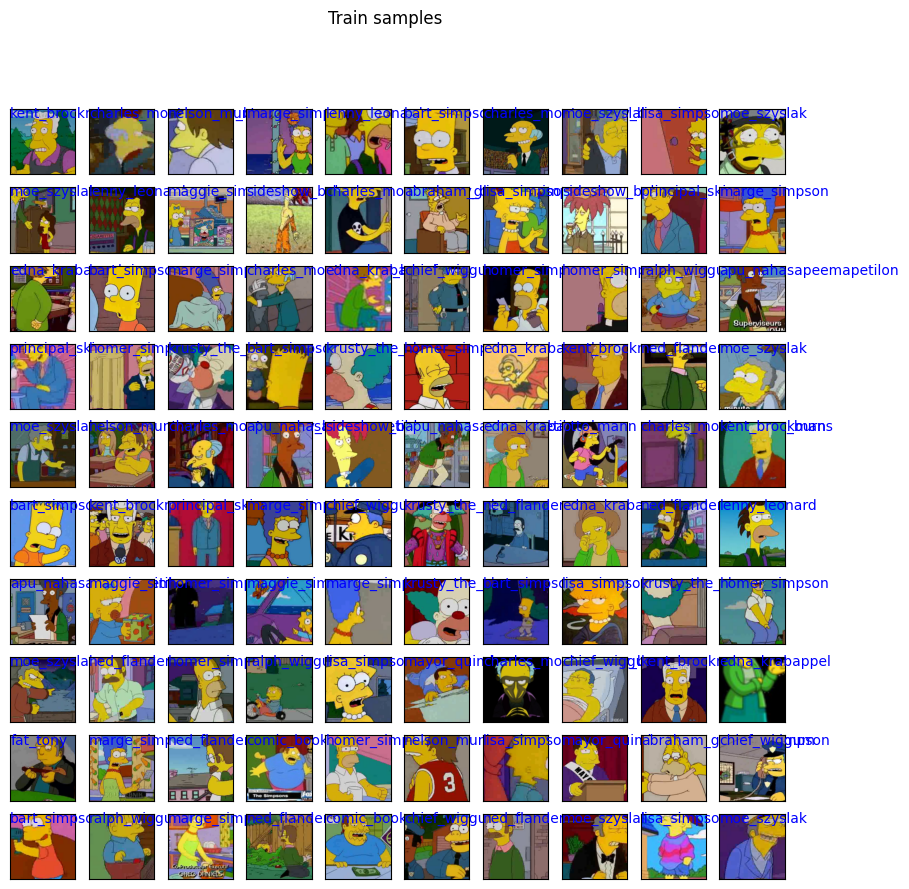

In [11]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img, label = images[i]
        original_img = img * torch.tensor(std).reshape(3, 1, 1) + torch.tensor(mean).reshape(3, 1, 1)
        img = original_img.numpy().transpose(1, 2, 0)
        img_label = images.label_encoder.inverse_transform([label]).item()
        ax.imshow((img * 255).astype('uint8'))
        ax.text(0, 27, str(img_label), color = 'b')

print(f'Number of train samples: {len(train_dataset)}')
show_images(train_dataset, 'Train samples')

In [12]:
def get_shape(dataset):
  n = len(dataset)
  c, h, w = dataset[0][0].numpy().shape
  return [n, *(dataset[0][0].numpy().shape)]

print(f'Shape of input train data: {get_shape(train_dataset)}')
print(f'Data type: {train_dataset[0][0].numpy().dtype}')

data_shape = get_shape(train_dataset)
data_shape[0] = 1

Shape of input train data: [35586, 3, 224, 224]
Data type: float32


# 2. Построение архитектуры сверточной сети

In [13]:
class Block(torch.nn.Module):
    def __init__(self, in_channel, cardinality=32, bottleneck_width=4, stride=1, factor=2):
        super(Block, self).__init__()
        self.factor = factor
        self.group_width = cardinality * bottleneck_width
        self.out_channel = self.factor * self.group_width
        self.conv1 = torch.nn.Conv2d(in_channel, self.group_width, kernel_size=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(self.group_width)
        self.group_conv2 = torch.nn.Conv2d(self.group_width, self.group_width, \
                                           kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(self.group_width)
        self.conv3 = torch.nn.Conv2d(self.group_width, self.out_channel, kernel_size=1, bias=False)
        self.bn3 = torch.nn.BatchNorm2d(self.out_channel)
        # to align shapes on the branches
        self.aligner = torch.nn.Sequential()
        if stride != 1 or in_channel != self.out_channel:
            self.aligner = torch.nn.Sequential(
                torch.nn.Conv2d(in_channel, self.out_channel, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(self.out_channel)
            )

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = torch.nn.functional.relu(self.bn2(self.group_conv2(out)))
        out = torch.nn.functional.relu(self.bn3(self.conv3(out)) + self.aligner(x))
        return out

In [14]:
class ResNeXt_32x4d(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(ResNeXt_32x4d, self).__init__()
        self.cardinality = 32
        self.bottleneck_width = 4
        self.channels = 64
        self.factor = 2
        self.count = 3

        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=1, stride=2, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)

        self.stage0 = self._get_stage(3, 2)
        self.stage1 = self._get_stage(3, 2)
        self.stage2 = self._get_stage(3, 2)
        
        self.linear = torch.nn.Linear(self.cardinality * self.bottleneck_width, num_classes)

    def _get_stage(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        blocks = []
        for stride in strides:
            block = Block(self.channels, self.cardinality, self.bottleneck_width, stride, self.factor)
            self.channels = block.out_channel
            blocks.append(block)
        self.bottleneck_width *= 2
        return torch.nn.Sequential(*blocks)

    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.stage0(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = torch.nn.functional.avg_pool2d(out, self.factor ** self.count)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [15]:
net_32x4d = ResNeXt_32x4d(len(classes))
y_32x4d = net_32x4d(torch.rand(1,3,224,224))
print(y_32x4d.shape)

torch.Size([1, 43])



(dot.exe:31028): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


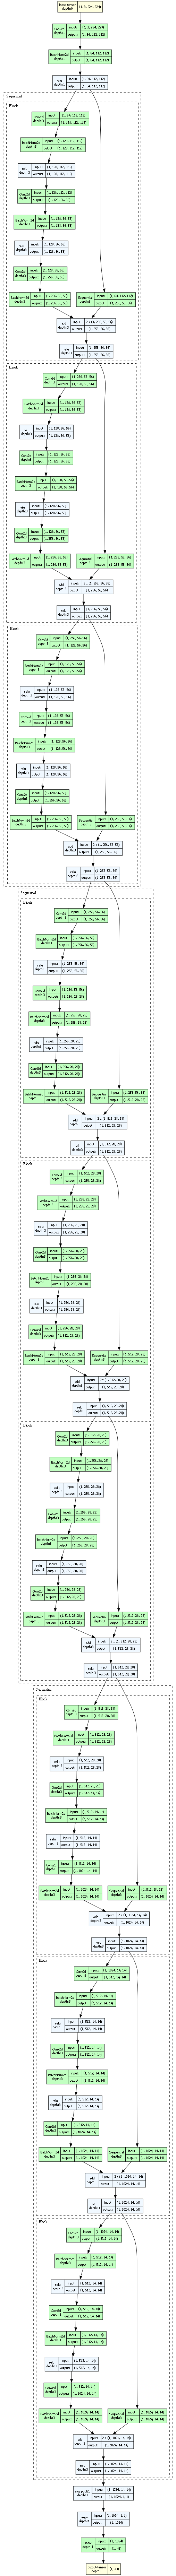

In [16]:
import graphviz
from torchview import draw_graph

graphviz.set_jupyter_format('png')
net_32x4d.to(device)
model_graph_32x4d = draw_graph(net_32x4d, input_size=data_shape, expand_nested=True, device=device)
model_graph_32x4d.visual_graph

# 3. Обучение сети

In [17]:
from sklearn.metrics import f1_score

def get_f1_score(model, data_loader, device):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().numpy())
            true.extend(labels.cpu().numpy())
    return f1_score(true, preds, average="weighted")

In [18]:
import time
from tqdm import tqdm

def train(model, data_loader, epochs, loss_function, optimizer, device):
    for epoch in range(epoches):
        t0 = time.time()
        for images, labels in tqdm(data_loader, total=len(data_loader)):
            images = images.to(device)
            labels = labels.to(device)
            y = model(images)
            loss = loss_function(y, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        t1 = time.time()
        print(f'Epoch[{epoch + 1}]: accuracy = {get_f1_score(model, data_loader, device)}, time = {t1 - t0}')
    print(f'Test accuracy: {get_f1_score(model, data_loader, device)}')

In [19]:
learning_rate = 0.001
epoches = 20

model_32x4d = ResNeXt_32x4d(len(classes))
model_32x4d = model_32x4d.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_32x4d.parameters(), lr = learning_rate)

print(f'Start of the training')
train(model_32x4d, train_loader, epoches, loss_function, optimizer, device)

Start of the training


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [45:00<00:00,  2.43s/it]


Epoch[1]: accuracy = 0.7307372882543538, time = 2700.324329853058


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:54<00:00,  2.37s/it]


Epoch[2]: accuracy = 0.8035285209099277, time = 2634.2081067562103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:53<00:00,  2.37s/it]


Epoch[3]: accuracy = 0.8867076503644392, time = 2633.356381893158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:53<00:00,  2.37s/it]


Epoch[4]: accuracy = 0.8896876189062372, time = 2633.401265144348


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:53<00:00,  2.37s/it]


Epoch[5]: accuracy = 0.9313794223442219, time = 2633.698470592499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:53<00:00,  2.37s/it]


Epoch[6]: accuracy = 0.92006914042914, time = 2633.9448103904724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:48<00:00,  2.36s/it]


Epoch[7]: accuracy = 0.9681628317841985, time = 2628.6719119548798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:47<00:00,  2.36s/it]


Epoch[8]: accuracy = 0.9645505332595126, time = 2627.941864967346


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:49<00:00,  2.36s/it]


Epoch[9]: accuracy = 0.9649763143216766, time = 2629.027961730957


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [43:55<00:00,  2.37s/it]


Epoch[10]: accuracy = 0.9737903558431686, time = 2635.9344897270203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [44:24<00:00,  2.39s/it]


Epoch[11]: accuracy = 0.9738013650313314, time = 2664.9902894496918


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [44:29<00:00,  2.40s/it]


Epoch[12]: accuracy = 0.975475960152473, time = 2669.9914197921753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [44:30<00:00,  2.40s/it]


Epoch[13]: accuracy = 0.9768702384754469, time = 2670.6389446258545


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1113/1113 [44:31<00:00,  2.40s/it]


Epoch[14]: accuracy = 0.9801424136844987, time = 2671.5861496925354


  1%|█▌                                                                                                                                                      | 11/1113 [00:26<45:01,  2.45s/it]


KeyboardInterrupt: 

In [21]:
torch.save(model_32x4d.state_dict(), 'simpsons_model.pth')

In [24]:
print(f'Validation accuracy: {get_f1_score(model_32x4d, val_loader, device)}')

Validation accuracy: 0.8476364078699995
